IBM Machine Learning Professional Certificate<br>
__Supervised Machine Learning: Regression__

# Regression for Laptop Price 
***

__Author__: Chawit Kaewnuratchadasorn<br>
__Date__: 12th Jan 2022<br>

This notebook was created for Supervised Machine Learning for Machine Learning course of IBM Machine Learning certificate. The dataset was obtained from Kaggle Dataset by Muhammet Varl. The link was attached below. In this notebook, the prediction for laptop price was conducted based on data in the dataset, following the course project instructions. This project aims to practice feature transformation and scale, linear regression, Lasso and Ridge regressions, and cross validations.

Data source: [Coursera Course Dataset](https://www.kaggle.com/muhammetvarl/laptop-price)

The contents include:
> 1. Overview of Dataset
> 2. Plan for Regression
> 3. Data Cleaning and Features Transformation
> 4. Regression
>>  Linear Regression<br>
>>  Lasso Regression<br>
>>  Ridge Regression<br>
> 5. Cross Validation
> 6. Summary and Future Plan

## Required Libraries

In [431]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_predict

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV

from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

def rmse(ytrue, ypredicted):
    return np.sqrt(mean_squared_error(ytrue, ypredicted))

## 1. Overview of Dataset

The dataset has 1303 rows with 13 columns. The columns consist of laptop id, company, product, type name, inches, scree resolution, cpu, ram, memory, gpu, operating system, weight, and price. The data is cleaned with no null. Big thanks to Kaggle and Muhammet Varl. The top 5 rows are shown below.

In [12]:
data = pd.read_csv('laptop_price.csv')
print("Number of rows in the data:", data.shape[0])
print("Number of columns in the data:", data.shape[1])

print([i for i in data.columns])

Number of rows in the data: 1303
Number of columns in the data: 13
['laptop_ID', 'Company', 'Product', 'TypeName', 'Inches', 'ScreenResolution', 'Cpu', 'Ram', 'Memory', 'Gpu', 'OpSys', 'Weight', 'Price_euros']


In [13]:
# Examine the columns, rows, and missing data
# Shows 5 first data
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   laptop_ID         1303 non-null   int64  
 1   Company           1303 non-null   object 
 2   Product           1303 non-null   object 
 3   TypeName          1303 non-null   object 
 4   Inches            1303 non-null   float64
 5   ScreenResolution  1303 non-null   object 
 6   Cpu               1303 non-null   object 
 7   Ram               1303 non-null   object 
 8   Memory            1303 non-null   object 
 9   Gpu               1303 non-null   object 
 10  OpSys             1303 non-null   object 
 11  Weight            1303 non-null   object 
 12  Price_euros       1303 non-null   float64
dtypes: float64(2), int64(1), object(10)
memory usage: 132.5+ KB


,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60


## 2. Plan for Regression

Before planning the regression, we need to the unique values of column. I plan to not use product name because it makes sense to not use that with regression for now.  After observing the data, I plan to use dummy variables for many columns because the data seem to be grouped, not continuous values... except the weight and inches.

Thus, I list unique values of each column below

In [19]:
for col in data:
    print(col, len(data[col].unique()))

laptop_ID 1303
Company 19
Product 618
TypeName 6
Inches 18
ScreenResolution 40
Cpu 118
Ram 9
Memory 39
Gpu 110
OpSys 9
Weight 179
Price_euros 791


My opinions :

> We will need to __transform__ *Cpu*, *Ram*, *Memory*, and *GPU*

> We will __drop__ *laptop_ID* and *Product* for training model.

> We can directly use __dummy variables__ to *Company*, *TypeName* and *OpSys*.

> We can also use __scaled vaules__ of *Inches* and *Weight*. 

## 3. Data Cleaning and Feature Transformation

Here, we will try to follow our plans. So we will first try to transform *Cpu*, *Ram*, *Memory*, and *GPU*. In this section, there will be 4 sections:

> 1. Transformation of CPU, GPU, Ram, Memory, Screen resolution, and Weight<br>
> 2. Dropping of Laptop ID and Product Name<br>
> 3. One Hot Encoding<br>
> 4. Scaling Data

We first copy data to new dataframe for later processes.

In [353]:
# Copy
laptop = data.copy()

# X and Y
y_col = "Price_euros"

y = laptop[y_col]
laptop = laptop.drop(y_col, axis=1)

### 3.1 Transformation of CPU, GPU, Ram, Memory, Screen resolution, and Weight

In [354]:
laptop.head()

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg


In [355]:
# CPU
laptop['Cpu'] = laptop['Cpu'].replace(regex=["Pentium Dual Core"], value="2-Core")
laptop['Cpu'] = laptop['Cpu'].replace(regex=["Pentium Quad Core"], value="4-Core")
laptop['Cpu'] = laptop['Cpu'].replace(regex=["Celeron Dual Core"], value="2-Core")
laptop['Cpu'] = laptop['Cpu'].replace(regex=["Celeron Quad Core"], value="4-Core")
laptop[['CPU','Model', 'Perform', 'Freq']] = laptop["Cpu"].str.split(" ",3, expand=True)

laptop['Freq'] = laptop['Freq'].str[-7:-3]
laptop['Freq'] = laptop['Freq'].replace(regex=["V6"], value="")
laptop['Freq'] = laptop['Freq'].replace(regex=["6U"], value="")
laptop['Freq'] = laptop['Freq'].astype(float)

In [356]:
# GPU
laptop[['GPU','Others']] = laptop["Gpu"].str.split(" ",1, expand=True)

In [357]:
# Ram
laptop["Ram"] = laptop['Ram'].replace(regex=["GB"], value="")
laptop['Ram'] = laptop['Ram'].astype(float)

In [358]:
# Memory
laptop['Memory'] = laptop['Memory'].replace(regex=["1TB"], value="1024GB")
laptop['Memory'] = laptop['Memory'].replace(regex=["1.0TB"], value="1024GB")
laptop['Memory'] = laptop['Memory'].replace(regex=["2TB"], value="2048GB")
laptop['Memory'] = laptop['Memory'].str[:6]
laptop['Memory'] = laptop['Memory'].replace(regex=["GB","G","GB S", "S", "H", "F"], value="")
laptop['Memory'] = laptop['Memory'].astype(float)

In [359]:
# ScreenResolution
laptop["ScreenResolution"] = laptop["ScreenResolution"].str[-9:]

In [360]:
# Weight
laptop['Weight'] = laptop['Weight'].str[:-2]
laptop['Weight'] = laptop['Weight'].astype(float)

In [361]:
laptop.head()

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,CPU,Model,Perform,Freq,GPU,Others
0,1,Apple,MacBook Pro,Ultrabook,13.3,2560x1600,Intel Core i5 2.3GHz,8.0,128.0,Intel Iris Plus Graphics 640,macOS,1.37,Intel,Core,i5,2.3,Intel,Iris Plus Graphics 640
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8.0,128.0,Intel HD Graphics 6000,macOS,1.34,Intel,Core,i5,1.8,Intel,HD Graphics 6000
2,3,HP,250 G6,Notebook,15.6,1920x1080,Intel Core i5 7200U 2.5GHz,8.0,256.0,Intel HD Graphics 620,No OS,1.86,Intel,Core,i5,2.5,Intel,HD Graphics 620
3,4,Apple,MacBook Pro,Ultrabook,15.4,2880x1800,Intel Core i7 2.7GHz,16.0,512.0,AMD Radeon Pro 455,macOS,1.83,Intel,Core,i7,2.7,AMD,Radeon Pro 455
4,5,Apple,MacBook Pro,Ultrabook,13.3,2560x1600,Intel Core i5 3.1GHz,8.0,256.0,Intel Iris Plus Graphics 650,macOS,1.37,Intel,Core,i5,3.1,Intel,Iris Plus Graphics 650


### 3.2 Dropping of Laptop ID and Product Name 

In [362]:
# Drop Laptop ID and Product Name
laptop = laptop.drop(['laptop_ID', 'Product'], axis = 1)

# Drop columns that we also do not use
laptop = laptop.drop(['Cpu','Gpu','Perform','Others'], axis = 1)

In [363]:
laptop.head()

,Company,TypeName,Inches,ScreenResolution,Ram,Memory,OpSys,Weight,CPU,Model,Freq,GPU
0,Apple,Ultrabook,13.3,2560x1600,8.0,128.0,macOS,1.37,Intel,Core,2.3,Intel
1,Apple,Ultrabook,13.3,1440x900,8.0,128.0,macOS,1.34,Intel,Core,1.8,Intel
2,HP,Notebook,15.6,1920x1080,8.0,256.0,No OS,1.86,Intel,Core,2.5,Intel
3,Apple,Ultrabook,15.4,2880x1800,16.0,512.0,macOS,1.83,Intel,Core,2.7,AMD
4,Apple,Ultrabook,13.3,2560x1600,8.0,256.0,macOS,1.37,Intel,Core,3.1,Intel


### 3.3 Dummy Variables for Company, Type name, and Operating System

Here, we apply one-hot method that we learned in the course to create dummy variables for our dataset

In [364]:
mask = laptop.dtypes == np.object
categorical_cols = laptop.columns[mask]
categorical_cols

mask = laptop.dtypes == np.float
numerical_cols = laptop.columns[mask]
numerical_cols

arranged_col = numerical_cols.tolist() + categorical_cols.tolist()
laptop = laptop[arranged_col]
laptop.head()

<ipython-input-364-3d25bcb37f52>:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = laptop.dtypes == np.object
<ipython-input-364-3d25bcb37f52>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = laptop.dtypes == np.float


,Inches,Ram,Memory,Weight,Freq,Company,TypeName,ScreenResolution,OpSys,CPU,Model,GPU
0,13.3,8.0,128.0,1.37,2.3,Apple,Ultrabook,2560x1600,macOS,Intel,Core,Intel
1,13.3,8.0,128.0,1.34,1.8,Apple,Ultrabook,1440x900,macOS,Intel,Core,Intel
2,15.6,8.0,256.0,1.86,2.5,HP,Notebook,1920x1080,No OS,Intel,Core,Intel
3,15.4,16.0,512.0,1.83,2.7,Apple,Ultrabook,2880x1800,macOS,Intel,Core,AMD
4,13.3,8.0,256.0,1.37,3.1,Apple,Ultrabook,2560x1600,macOS,Intel,Core,Intel


In [365]:
num_ohc_cols = (laptop[categorical_cols]
                .apply(lambda x: x.nunique())
                .sort_values(ascending=False))


# No need to encode if there is only one value
small_num_ohc_cols = num_ohc_cols.loc[num_ohc_cols>1]

# Number of one-hot columns is one less than the number of categories
small_num_ohc_cols -= 1

# This is 215 columns, assuming the original ones are dropped. 
# This is quite a few extra columns!
small_num_ohc_cols.sum()

65

In [366]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Copy of the data
laptop_ohc = laptop.copy()

# The encoders
le = LabelEncoder()
ohc = OneHotEncoder()

for col in num_ohc_cols.index:
    
    # Integer encode the string categories
    dat = le.fit_transform(laptop_ohc[col]).astype(np.int)
    
    # Remove the original column from the dataframe
    laptop_ohc = laptop_ohc.drop(col, axis=1)

    # One hot encode the data--this returns a sparse array
    new_dat = ohc.fit_transform(dat.reshape(-1,1))

    # Create unique column names
    n_cols = new_dat.shape[1]
    col_names = ['_'.join([col, str(x)]) for x in range(n_cols)]

    # Create the new dataframe
    new_df = pd.DataFrame(new_dat.toarray(), 
                          index=laptop_ohc.index, 
                          columns=col_names)

    # Append the new data to the dataframe
    laptop_ohc = pd.concat([laptop_ohc, new_df], axis=1)

<ipython-input-366-70286c5af517>:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dat = le.fit_transform(laptop_ohc[col]).astype(np.int)
<ipython-input-366-70286c5af517>:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Depreca

In [367]:
laptop_ohc.head()

,Inches,Ram,Memory,Weight,Freq,Company_0,Company_1,Company_2,Company_3,Company_4,...,TypeName_3,TypeName_4,TypeName_5,GPU_0,GPU_1,GPU_2,GPU_3,CPU_0,CPU_1,CPU_2
0,13.3,8.0,128.0,1.37,2.3,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,13.3,8.0,128.0,1.34,1.8,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,15.6,8.0,256.0,1.86,2.5,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,15.4,16.0,512.0,1.83,2.7,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,13.3,8.0,256.0,1.37,3.1,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


### 3.4 Scaling data

In this section, we apply standard scaler to Inches, Ram, Memory, Weight, and Frequencies.

In [368]:
from sklearn.preprocessing import StandardScaler

s = StandardScaler()

laptop_ss_array = s.fit_transform(laptop_ohc[numerical_cols])

laptop_ss = pd.DataFrame(laptop_ss_array, columns = ['Inches_ss','Ram_ss','Memory_ss','Weight_ss', "Freq_sss"])

laptop_ohc_ss = pd.concat([laptop_ohc, laptop_ss], axis=1)

laptop_ohc_ss = laptop_ohc_ss.drop(numerical_cols, axis = 1)

laptop_ohc_ss.head()

,Company_0,Company_1,Company_2,Company_3,Company_4,Company_5,Company_6,Company_7,Company_8,Company_9,...,GPU_2,GPU_3,CPU_0,CPU_1,CPU_2,Inches_ss,Ram_ss,Memory_ss,Weight_ss,Freq_sss
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,-1.204407,-0.075195,-0.874044,-1.005283,0.002426
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,-1.204407,-0.075195,-0.874044,-1.050381,-0.985431
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.408772,-0.075195,-0.524218,-0.268684,0.397569
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.268495,1.498767,0.175433,-0.313782,0.792712
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,-1.204407,-0.075195,-0.524218,-1.005283,1.582997


The table *laptop_ohc_ss* is for feature data or X. We also need to scale label data or Y as well.

In [371]:
s = StandardScaler()

y_shaped = y.values.reshape(len(y),1)
y_ss = s.fit_transform(y_shaped)

0.30901318194553995

## 4. Regression

In this section, we first split training and testing sets of dataset by sklearn library. Then, we will explore each type of regression to obtain our models. Thus, this section will contain

> Linear Regression<br>
>  Lasso Regression<br>
>  Ridge Regression<br>

### Split Training and Testing dataset

In [421]:
from sklearn.model_selection import train_test_split

X_data = laptop_ohc_ss.copy()
y_data = y_ss.copy()

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, 
                                                    test_size=0.3, random_state=42)

### Linear Regression

In [422]:
from sklearn.linear_model import LinearRegression

linearRegression = LinearRegression().fit(X_train, y_train)

linearRegression_rmse = rmse(y_test, linearRegression.predict(X_test))

error_df = list()

error_df.append(pd.Series({'train': rmse(y_train, linearRegression.predict(X_train)),
                           'test' : rmse(y_test,  linearRegression.predict(X_test))},
                           name='LR'))

print('train:', rmse(y_train, linearRegression.predict(X_train)))
print('test:', rmse(y_test,  linearRegression.predict(X_test)))

train: 0.43784387499586086
test: 0.49315203512278566


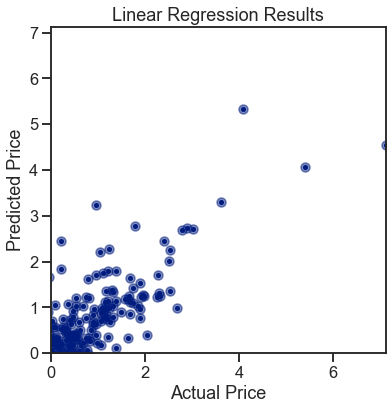

In [423]:
sns.set_context('talk')
sns.set_style('ticks')
sns.set_palette('dark')

f = plt.figure(figsize=(6,6))
ax = plt.axes()

ax.plot(y_test, linearRegression.predict(X_test), 
         marker='o', ls='', ms=4.0)

ax.scatter(y_test, linearRegression.predict(X_test), alpha=.5)

lim = (0, y_test.max())

ax.set(xlabel='Actual Price', 
       ylabel='Predicted Price', 
       xlim=lim,
       ylim=lim,
       title='Linear Regression Results');

### LASSO Regression

In [424]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures

lr = Lasso(alpha = 0.001, max_iter= 10000)
lr.fit(X_train, y_train)

error_df.append(pd.Series({'train': rmse(y_train, lr.predict(X_train)),
                           'test' : rmse(y_test, lr.predict(X_test))},
                           name='Lasso'))

print('train:', rmse(y_train, lr.predict(X_train)))
print('test:', rmse(y_test, lr.predict(X_test)))

train: 0.44394101507710915
test: 0.5054357386476939


### Ridge Regression

In [425]:
from sklearn.linear_model import Ridge

r = Ridge(alpha = 0.001)
r.fit(X_train, y_train)

error_df.append(pd.Series({'train': rmse(y_train, r.predict(X_train)),
                           'test' : rmse(y_test, r.predict(X_test))},
                           name='Ridge'))

print('train:', rmse(y_train, r.predict(X_train)))
print('test:', rmse(y_test, r.predict(X_test)))

train: 0.4378438786589009
test: 0.4931548573690608


In [426]:
error_df = pd.concat(error_df, axis=1)
error_df

,LR,Lasso,Ridge
train,0.437844,0.443941,0.437844
test,0.493152,0.505436,0.493155


## 5. Cross Validation

In this section, we perform GridSearch CV, Lasso CV, and Ridge CV.

### GridSearch CV

In [461]:
from sklearn.model_selection import GridSearchCV

# Same estimator as before
estimator = Pipeline([("scaler", StandardScaler()),
        ("polynomial_features", PolynomialFeatures()),
        ("ridge_regression", Ridge())])

params = {
    'polynomial_features__degree': [1, 2, 3],
    'ridge_regression__alpha': np.geomspace(4, 20, 30)
}

grid = GridSearchCV(estimator, params, cv=kf)

grid.fit(X_train, y_train)

y_predict = grid.predict(X_test)

print(rmse(y_test, grid.predict(X_test))) 

0.49262318912366326


### Lasso CV

In [455]:
from sklearn.linear_model import LassoCV

alphas2 = np.array([1e-5, 5e-5, 0.0001, 0.0005])

lassoCV = LassoCV(alphas=alphas2,
                  max_iter=5e4,
                  cv=3).fit(X_train, y_train)

lassoCV_rmse = rmse(y_test, lassoCV.predict(X_test))

print(lassoCV.alpha_, lassoCV_rmse) 

0.0005 0.4983255593964739


/Users/boomchawit/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


### Ridge CV

In [446]:
from sklearn.linear_model import RidgeCV

alphas = [0.005, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 80]

ridgeCV = RidgeCV(alphas=alphas, 
                  cv=4).fit(X_train, y_train)

ridgeCV_rmse = rmse(y_test, ridgeCV.predict(X_test))

print(ridgeCV.alpha_, ridgeCV_rmse)

3.0 0.5057361835668316


## 6. Summary

In this notebook, we have predicted the price of laptop based on the components. It seems that Ridge regression with GridSearch cross validation. The rmse was reported to be 0.492. The model could be further improved by adding polynnomial features as well as preparing more and better data. 

In this notebook, we have learned Regression and Crosss Validation throughout predicting price of laptop.